In [46]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from copy import deepcopy
import time
import warnings
%matplotlib inline

import nltk
from nltk import WordNetLemmatizer, pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc, accuracy_score

stop_words = stopwords.words('english')

#### Yelp Sentiment Analysis

The purpose of this project is to use Yelp reviews to train a supervised classification model to predict positive or negative sentiment.  Using NLP processing, proper vectorization techniques, and an ideal model, the goal is to make such predictions with the highest possible accuracy.

#### The Data

The data being used in this project is provided by Yelp via Kaggle.  Although it originally contained 5 .json files with lots of data on all sorts of aspects of Yelp including user interactions and status, business information and ratings, check-ins, and much more, this project is focused only on the review text and associated rating.  For this reason and because of the size of the dataset, there is a separate notebook (yelp_dataset.ipnyb) in the repo containing my code to select the necessary information using SQL and re-structuring the relevant information into a new .csv file that can be accessed in the Data folder.

Documentation:  https://www.yelp.com/dataset/documentation/main

User Agreement:  Included in the Data folder of this repo

#### Defining Preprocessing Classes

After making the necessary imports, I've defined the following two classes to make lemmatization and stemming easier later on.  They also contain standard preprocessing steps such as removing stop words, making all characters lower case, and omitting numbers and punctuation.

In [47]:
class LemmPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y = 0):
        return self

    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.process_doc)
        return normalized_corpus

    def process_doc(self, doc):
        lemm = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None
        normalized_doc = [token.lower() for token in word_tokenize(doc) if ((token.isalpha()) & (token not in stop_words))]
        tagged_tokens = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(normalized_doc)))
        normalized_doc = [lemm.lemmatize(token, pos) for token, pos in tagged_tokens if pos is not None]
        return " ".join(normalized_doc)

In [48]:
class StemPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data, y = 0):
        return self

    def transform(self, data, y = 0):
        normalized_corpus = data.apply(self.stem_doc)
        return normalized_corpus
        
    def stem_doc(self, doc):
        stemmer = SnowballStemmer('english')
        lower_doc = [token.lower() for token in word_tokenize(doc) if token.isalpha()]
        filtered_doc = [token for token in lower_doc if token not in stop_words]
        stemmed_doc = [stemmer.stem(token) for token in filtered_doc]
        return " ".join(stemmed_doc)

####  Managing Data Size

This code block will take an hour or so to run.  In this section, I loop through various potential data subset sizes to determine what can be practically worked with giving my time constraints (one week) for this project while also providing a the highest possible accuracy given that limitation.  After filtering out 3-star reviews and businesses that are not restaurants, I was still left with about 4.5 million rows!

The range of possible sizes I tested is 10,000 to 100,000.

Minimum:  10,000 was the smallest data set I would feel comfortable with.  Anything less than 10,000 would leave a large amount of doubt as to the significance of the results, which would defeat the purpose of the project.

Maximum:  Although there is always the potential of higher accuracy with more data, I felt the need to cap this loop at 100,000 as I need to test out several different models, write presentations, markdown, and more and am unable to wait 3+ hours for the code to run.  If I were to have more time, I would be interested in testing out even larger datasets to work with.

In [50]:
runtime_dict = {}
accuracy_dict_cv_multinb = {}
accuracy_dict_tfidf_multinb = {}
accuracy_dict_cv_compnb = {}
accuracy_dict_tfidf_compnb = {}

def assign_value(star_rating):
    if star_rating in [1, 2]:
        return 0
    elif star_rating in [4, 5]:
        return 1
        
for n in [10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 80000, 90000, 100000]:
    df = pd.read_csv('Data/yelp_restaurant_reviews.csv')
    start_time_read = time.time()
    df = df.sample(n = n, random_state = 100)
    df['sentiment'] = df['stars'].apply(lambda x: assign_value(x))
    df = df.drop(columns = 'stars', axis = 1)
    end_time_read = time.time()
    elapsed_time_read = end_time_read - start_time_read

    start_time_transform = time.time()
    X = df['review_text']
    y = df['sentiment']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)
    processor = LemmPreprocessor()
    X_train_transformed = processor.fit_transform(X_train)
    X_test_transformed = processor.transform(X_test)
    end_time_transform = time.time()
    elapsed_time_transform = end_time_transform - start_time_transform
    
    start_time_vector = time.time()
    cv_pipe = Pipeline([('countvec', CountVectorizer())])
    X_train_cv = cv_pipe.fit_transform(X_train_transformed)
    X_train_cv = X_train_cv.astype(np.int32)
    X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns = cv_pipe['countvec'].get_feature_names())
    X_train_cv_df['sentiment'] = y_train
    
    end_time_vector = time.time()
    elapsed_time_vector = end_time_vector - start_time_vector

    start_time_model = time.time()
    cv_multinb_pipe = deepcopy(cv_pipe)
    cv_multinb_pipe.steps.append(('multinb', MultinomialNB()))
    cv_multinb_pipe.fit(X_train_transformed, y_train)
    y_pred_cv_multinb = cv_multinb_pipe.predict(X_test_transformed)

    tfidf_multinb_pipe = deepcopy(cv_multinb_pipe)
    tfidf_multinb_pipe.steps[0] = ('tfidf', TfidfVectorizer())
    tfidf_multinb_pipe.fit(X_train_transformed, y_train)
    y_pred_tfidf_multinb = tfidf_multinb_pipe.predict(X_test_transformed)

    cv_compnb_pipe = deepcopy(cv_pipe)
    cv_compnb_pipe.steps.append(('compnb', ComplementNB()))
    cv_compnb_pipe.fit(X_train_transformed, y_train)
    y_pred_cv_compnb = cv_compnb_pipe.predict(X_test_transformed)

    tfidf_compnb_pipe = deepcopy(tfidf_multinb_pipe)
    tfidf_compnb_pipe.steps[1] = ('compnb', ComplementNB())
    tfidf_compnb_pipe.fit(X_train_transformed, y_train)
    y_pred_tfidf_compnb = tfidf_compnb_pipe.predict(X_test_transformed)

    end_time_model = time.time()
    elapsed_time_model = end_time_model - start_time_model

    total_time = elapsed_time_read + elapsed_time_transform + elapsed_time_vector + elapsed_time_model
    accuracy_cv_multinb = accuracy_score(y_test, y_pred_cv_multinb)
    accuracy_tfidf_multinb = accuracy_score(y_test, y_pred_tfidf_multinb)
    accuracy_cv_compnb = accuracy_score(y_test, y_pred_cv_compnb)
    accuracy_tfidf_compnb = accuracy_score(y_test, y_pred_tfidf_compnb)

    runtime_dict[n] = total_time
    accuracy_dict_cv_multinb[n] = accuracy_cv_multinb
    accuracy_dict_tfidf_multinb[n] = accuracy_tfidf_multinb
    accuracy_dict_cv_compnb[n] = accuracy_cv_compnb
    accuracy_dict_tfidf_compnb[n] = accuracy_tfidf_compnb
    

    print(f"{n} REVIEWS")
    print("-----------------------------------------------")
    print(f"Class Balance: {(df['sentiment'].value_counts(normalize = True)[1] * 100):.2f}% positive and {(df['sentiment'].value_counts(normalize = True)[0] * 100):.2f}% negative")
    print(f"Read Time: {elapsed_time_read:.2f} seconds")
    print(f"Transformation Time: {elapsed_time_transform:.2f} seconds")
    print(f"Count Vectorization Time: {elapsed_time_vector:.2f} seconds")
    print(f"Model Run Time: {elapsed_time_model:.2f} seconds")
    print(f"Accuracy, Multinomial Naive Bayes and Count Vectorization: {accuracy_cv_multinb:.4f}")
    print(f"Accuracy, Multinomial Naive Bayes and TF-IDF: {accuracy_tfidf_multinb:.4f}")
    print(f"Accuracy, Complement Naive-Bayes and Count Vectorization: {accuracy_cv_compnb:.4f}")
    print(f"Accuracy, Complement Naive-Bayes and TF-IDF: {accuracy_tfidf_compnb:.4f}")
    print(f"Total Run Time: {total_time:.2f} seconds")
    print("")
    print("")

10000 REVIEWS
-----------------------------------------------
Class Balance: 77.18% positive and 22.82% negative
Read Time: 0.34 seconds
Transformation Time: 43.95 seconds
Count Vectorization Time: 0.37 seconds
Model Run Time: 1.39 seconds
Accuracy, Multinomial Naive Bayes and Count Vectorization: 0.9233
Accuracy, Multinomial Naive Bayes and TF-IDF: 0.8160
Accuracy, Complement Naive-Bayes and Count Vectorization: 0.9243
Accuracy, Complement Naive-Bayes and TF-IDF: 0.8727
Total Run Time: 46.05 seconds


15000 REVIEWS
-----------------------------------------------
Class Balance: 77.05% positive and 22.95% negative
Read Time: 0.34 seconds
Transformation Time: 67.05 seconds
Count Vectorization Time: 0.54 seconds
Model Run Time: 2.09 seconds
Accuracy, Multinomial Naive Bayes and Count Vectorization: 0.9220
Accuracy, Multinomial Naive Bayes and TF-IDF: 0.8262
Accuracy, Complement Naive-Bayes and Count Vectorization: 0.9238
Accuracy, Complement Naive-Bayes and TF-IDF: 0.8927
Total Run Time: 

#### Selecting the Ideal Data Size, Vectorization Method, and Model

Data Size:  After running the loop, the data size with the highest accuracy was 30,000.  Over 30,000, the models using Count Vectorization actually decreased in accuracy and increased in runtime.  This was a reasonable size to work with and provided a accuracy score of ~0.9358, which is definitely a good score to start with.  Comparatively, the class balance has about 77% positive, so with that as a baseline, 93.58% is a marked improvement.

Vectorization:  The models using Count Vectorization decidedly out-performed those using TF-IDF.  However, it is important to note that this is largely due to my time/data size constraints.  The Count Vectorizations easily reached accuracy scores over 0.90, but tend to flatline and not show much improvement on larger datasets.  The models using TF-IDF Vectorization did not show nearly as impressive accuracy scores on the relatively small datasets, but do show a slow, but steady increase in score as data size increased.  Given more time, it is certainly possible that using TF-IDF as the vectorization method could provide even higher accuracy on larger datasets, up to the full 4.5 million rows.

Model:  The Multinomial Naive-Bayes slightly out-performed the Complement Naive-Bayes when using Count Vectorization.  Worth noting, however, is that the Complement Naive-Bayes significantly out-performed the Multinomial Naive-Bayes when using TF-IDF.

Conclusion:  For datasets using 10,000 - 100,000 rows from the overall ~4.5 million, the Multionmial Naive-Bayes model using Count Vectorization performed best with an accuracy score of ~0.9358.  It is important to understand that this finding is only relevant to the datasets within that size range.  It is certainly possible that for larger subsets or even the full dataset, that the Complement Naive-Bayes with TF-IDF vectorization would provide even higher accuracy scores.

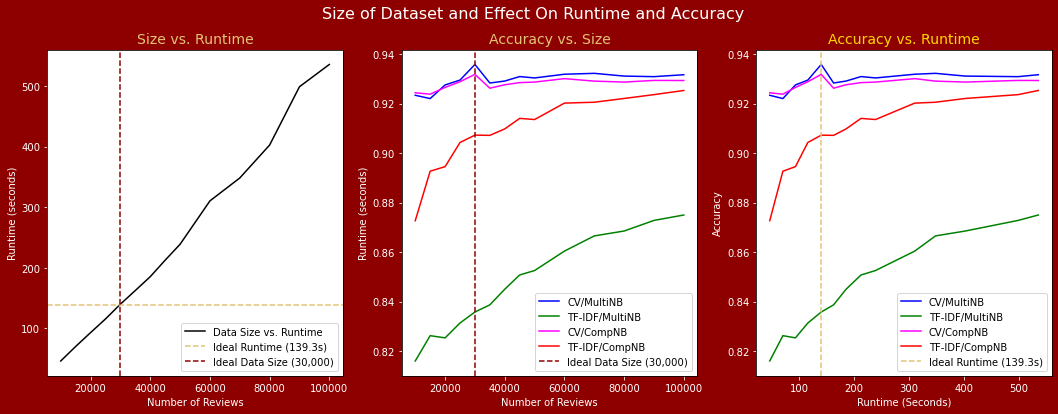

In [52]:
n_values = list(runtime_dict.keys())
runtimes = list(runtime_dict.values())
accuracy_scores_cv_multinb = list(accuracy_dict_cv_multinb.values())
accuracy_scores_tfidf_multinb = list(accuracy_dict_tfidf_multinb.values())
accuracy_scores_cv_compnb = list(accuracy_dict_cv_compnb.values())
accuracy_scores_tfidf_compnb = list(accuracy_dict_tfidf_compnb.values())

fig, axes = plt.subplots(1, 3, figsize = (18, 6))
plt.suptitle('Size of Dataset and Effect On Runtime and Accuracy', color = 'white', fontsize = 16)
fig.patch.set_facecolor('#8E0000')

axes[0].plot(n_values, runtimes, color = 'black', label = 'Data Size vs. Runtime')
axes[0].axhline(y = 139.3, color = '#E3C375', linestyle = '--', label = 'Ideal Runtime (139.3s)')
axes[0].axvline(x = 30000, color = '#8E0000', linestyle = '--', label = 'Ideal Data Size (30,000)')
axes[0].set_title('Size vs. Runtime', color = '#E3C375', fontsize = 14)
axes[0].set_xlabel('Number of Reviews', color = 'white')
axes[0].tick_params(axis = 'x', colors = 'white')
axes[0].set_ylabel('Runtime (seconds)', color = 'white')
axes[0].tick_params(axis = 'y', colors = 'white')
axes[0].legend()

axes[1].plot(n_values, accuracy_scores_cv_multinb, color = 'b', label = 'CV/MultiNB')
axes[1].plot(n_values, accuracy_scores_tfidf_multinb, color = 'g', label = 'TF-IDF/MultiNB')
axes[1].plot(n_values, accuracy_scores_cv_compnb, color = 'fuchsia', label = 'CV/CompNB')
axes[1].plot(n_values, accuracy_scores_tfidf_compnb, color = 'r', label = 'TF-IDF/CompNB')
axes[1].axvline(x = 30000, color = '#8E0000', linestyle = '--', label = 'Ideal Data Size (30,000)')
axes[1].set_title('Accuracy vs. Size', color = '#E3C375', fontsize = 14)
axes[1].set_xlabel('Number of Reviews', color = 'white')
axes[1].tick_params(axis = 'x', colors = 'white')
axes[1].set_ylabel('Runtime (seconds)', color = 'white')
axes[1].tick_params(axis = 'y', colors = 'white')
axes[1].legend()

axes[2].plot(runtimes, accuracy_scores_cv_multinb, color = 'b', label = 'CV/MultiNB')
axes[2].plot(runtimes, accuracy_scores_tfidf_multinb, color = 'g', label = 'TF-IDF/MultiNB')
axes[2].plot(runtimes, accuracy_scores_cv_compnb, color = 'fuchsia', label = 'CV/CompNB')
axes[2].plot(runtimes, accuracy_scores_tfidf_compnb, color = 'r', label = 'TF-IDF/CompNB')
axes[2].axvline(x = 139.3, color = '#E3C375', linestyle = '--', label = 'Ideal Runtime (139.3s)')
axes[2].set_title('Accuracy vs. Runtime', color = 'gold', fontsize = 14)
axes[2].set_xlabel('Runtime (Seconds)', color = 'white')
axes[2].tick_params(axis = 'x', colors = 'white')
axes[2].set_ylabel('Accuracy', color = 'white')
axes[2].tick_params(axis = 'y', colors = 'white')
axes[2].legend()

plt.savefig('size_runtime.png', dpi=300)
plt.show()

#### Preprocessing Techniques

After deciding on using a subset of 30,000 rows from the initial dataset, I decided to examine two different preprocessing techniques - stemming and lemmatization.  More specifically, I used SnowballStemmer and WordNetLemmatizer.  Both preprocessing techniques are initialized below, but the class and its methods are defined at the beginning of this notebook.

Similarly to the size loop, I used accuracy and runtime as metrics to evaluate the model.  Using the above findings, I use Multinomial Naive-Bayes as the model and Count Vectorization as the vectorization method.

In [129]:
n = 30000
df = pd.read_csv('Data/yelp_restaurant_reviews.csv')
df = df.sample(n = n, random_state = 100)
df['sentiment'] = df['stars'].apply(lambda x: assign_value(x))
df = df.drop(columns = 'stars', axis = 1)

In [130]:
lemm_start = time.time()

X_lemm = df['review_text']
y_lemm = df['sentiment']
X_train_lemm, X_test_lemm, y_train_lemm, y_test_lemm = train_test_split(X_lemm, y_lemm, test_size = 0.3, random_state = 100)
lemm = LemmPreprocessor()
X_train_transformed_lemm = lemm.fit_transform(X_train_lemm)
X_test_transformed_lemm = lemm.transform(X_test_lemm)
cv_pipe = Pipeline([('countvec', CountVectorizer())])
X_train_cv_lemm = cv_pipe.fit_transform(X_train_transformed_lemm)
X_train_cv_lemm = X_train_cv_lemm.astype(np.int32)
X_train_cv_df_lemm = pd.DataFrame(X_train_cv_lemm.toarray(), columns = cv_pipe['countvec'].get_feature_names())

pipe_lemm = deepcopy(cv_pipe)
pipe_lemm.steps.append(('multinb', MultinomialNB()))
pipe_lemm.fit(X_train_transformed_lemm, y_train_lemm)
y_pred_lemm = pipe_lemm.predict(X_test_transformed_lemm)
lemm_score = accuracy_score(y_test_lemm, y_pred_lemm)


lemm_end = time.time()
lemm_runtime = lemm_end - lemm_start

In [131]:
stem_start = time.time()

X_stem = df['review_text']
y_stem = df['sentiment']
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem, test_size = 0.3, random_state = 100)

stem = StemPreprocessor()
X_train_transformed_stem = stem.fit_transform(X_train_stem)
X_test_transformed_stem = stem.transform(X_test_stem)
    
cv_pipe_stem = Pipeline([('countvec', CountVectorizer())])
X_train_stem = cv_pipe_stem.fit_transform(X_train_transformed_stem, y_train_stem)
X_train_stem = X_train_stem.astype(np.int32)
X_train_stem = pd.DataFrame(X_train_stem.toarray(), columns = cv_pipe_stem['countvec'].get_feature_names(), index = X_train_transformed_stem.index)
pipe_stem = deepcopy(cv_pipe_stem)
pipe_stem.steps.append(('multinb', MultinomialNB()))
pipe_stem.fit(X_train_transformed_stem, y_train_stem)
y_pred_stem = pipe_stem.predict(X_test_transformed_stem)
stem_score = accuracy_score(y_test_stem, y_pred_stem)

stem_end = time.time()
stem_runtime = stem_end - stem_start

In [132]:
print(f"Accuracy Score using Lemmatization: {lemm_score:.4f}")
print(f"Runtime using Lemmatization: {lemm_runtime:.2f} seconds")
print(f"Accuracy Score using Stemming: {stem_score:.4f}")
print(f"Runtime using Stemming: {stem_runtime: .2f} seconds")

Accuracy Score using Lemmatization: 0.9358
Runtime using Lemmatization: 134.11 seconds
Accuracy Score using Stemming: 0.9334
Runtime using Stemming:  45.00 seconds


#### Evaluation

At this point, I have chosen the ideal data subset size, vectorization method, and model to use for the highest possible accuracy score.  After running the above code, I have now chosen lemmatization as the best preprocessing technique.  Although the score increase is small and the increase in runtime is relatively large, it is still only an extra  1.5-2 minutes wait time, which is well worth improving the model's accuracy.

Below, I have generated a few visualizations and scores to better understand the model's performance.  In order:

Confusion Matrix:  Because there is a class imbalance and the target variable is binary, one interpretable way to show the model's true performance is with a confusion matrix.  When examining, we can see that the model does better predicting positives than negatives.

ROC Curve/ AUC:  Since the data is largely skewed toward the positive side, I created a visualization of the ROC curve to compare to the accuracy score.  We can see that the AUC is 0.96 which is definitely strong, but mostly shows the model's performance on positive sentiment accuracy.

Classification Report:  Because there isn't necessarily one scoring metric that is better than the other, I also printed a classification report to show the full picture of the model's performance.

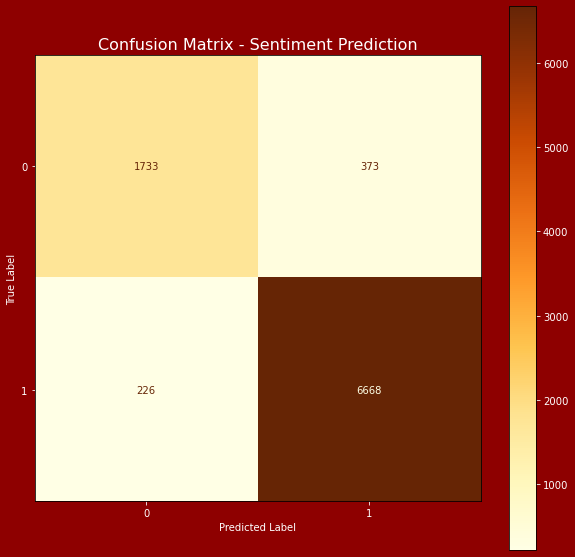

In [119]:
cm = confusion_matrix(y_test_lemm, y_pred_lemm)

fig, ax = plt.subplots(figsize = (10, 10))
fig.patch.set_facecolor('#8E0000')

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipe_lemm.classes_)
cm_display.plot(ax = ax, cmap='YlOrBr')
ax.tick_params(axis = 'both', colors = 'white')
for tick_label in ax.get_xticklabels() + ax.get_yticklabels():
    tick_label.set_color('white')
cbar_ax = ax.figure.axes[-1]
cbar_ax.yaxis.label.set_color('white')
cbar_ax.tick_params(axis = 'y', colors = 'white')
ax.set_title('Confusion Matrix - Sentiment Prediction', color = 'white', fontsize = 16)
ax.set_xlabel('Predicted Label', color = 'white')
ax.set_ylabel('True Label', color = 'white')

plt.savefig('cfm_sentiment.png', dpi=300)
plt.show()

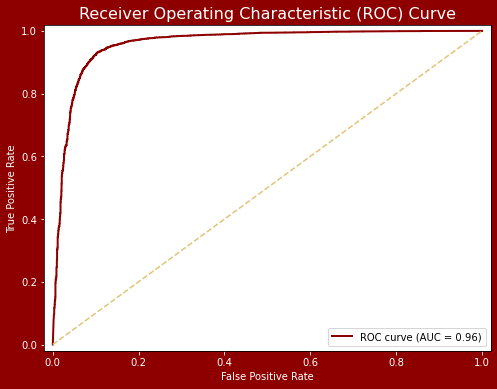

In [120]:
y_probs = pipe_lemm.predict_proba(X_test_transformed_lemm)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_lemm, y_probs)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (8, 6))
fig.patch.set_facecolor('#8E0000')

ax.plot(fpr, tpr, color='#8E0000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='#E3C375', linestyle='--')
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.set_title('Receiver Operating Characteristic (ROC) Curve', color = 'white', fontsize = 16)
ax.set_xlabel('False Positive Rate', color = 'white')
ax.tick_params(axis = 'x', colors = 'white')
ax.set_ylabel('True Positive Rate', color = 'white')
ax.tick_params(axis = 'y', colors = 'white')
ax.legend(loc="lower right")

plt.savefig('roc_auc.png', dpi=300)
plt.show()

In [121]:
print(classification_report(y_test_lemm, y_pred_lemm))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2106
           1       0.95      0.97      0.96      6894

    accuracy                           0.93      9000
   macro avg       0.92      0.90      0.90      9000
weighted avg       0.93      0.93      0.93      9000



In [122]:
print(f"Class Balance: {(df['sentiment'].value_counts(normalize = True)[1] * 100):.2f}% positive and {(df['sentiment'].value_counts(normalize = True)[0] * 100):.2f}% negative")

Class Balance: 76.87% positive and 23.13% negative


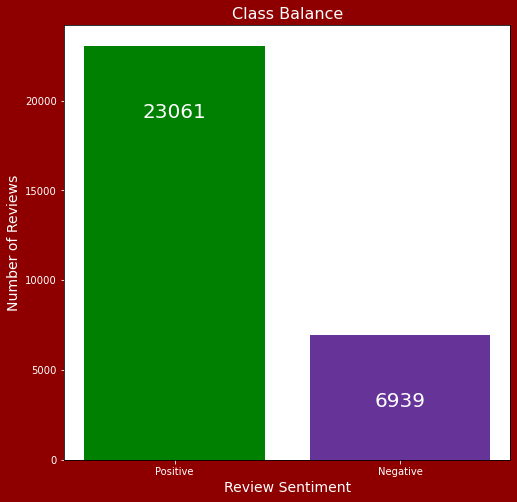

In [123]:
pos = df['sentiment'].value_counts()[1]
neg = df['sentiment'].value_counts()[0]
class_labels = ['Positive', 'Negative']
class_counts = [pos, neg]

fig, ax = plt.subplots(figsize = (8, 8))
fig.patch.set_facecolor('#8E0000')
bars = ax.bar(class_labels, class_counts, color = ['green', 'rebeccapurple'])
ax.set_title('Class Balance', color = 'white', fontsize = 16)
ax.set_xlabel('Review Sentiment', color = 'white', fontsize = 14)
ax.tick_params(axis = 'x', colors = 'white')
ax.set_ylabel('Number of Reviews', color = 'white', fontsize = 14)
ax.tick_params(axis = 'y', colors = 'white')

for bar, count in zip(bars, class_counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 4000, str(count), ha='center', color='white', fontsize=20)

plt.savefig('class_balance.png', dpi=300)
plt.show()

#### Probability of Words Appearing in Positive/Negative Reviews

The most significant use of this project is to gain an understanding of which subjects have the highest impact on guest sentiment of a restaurant.  By understanding this, the restaurant owner can appropriately allocate resources, management can adjust priorities, and staff can be trained to maximize positive sentiment.

The first step is to understand which words show the highest probability of appearing in positive reviews and negative reviews.

In [124]:
X_train_cv_df_lemm['sentiment'] = y_train_lemm
pos_train_df = X_train_cv_df_lemm[X_train_cv_df_lemm['sentiment'] == 1].drop(columns = ['sentiment'])
neg_train_df = X_train_cv_df_lemm[X_train_cv_df_lemm['sentiment'] == 0].drop(columns = ['sentiment'])

pos_occur = pos_train_df.sum(axis = 0)
pos_count = pos_train_df.values.sum()
proba_pos = pos_occur / pos_count

neg_occur = neg_train_df.sum(axis = 0)
neg_count = neg_train_df.values.sum()
proba_neg = neg_occur / neg_count

proba_pos_15 = proba_pos.sort_values(ascending = False)[0:15]
proba_neg_15 = proba_neg.sort_values(ascending = False)[0:15]

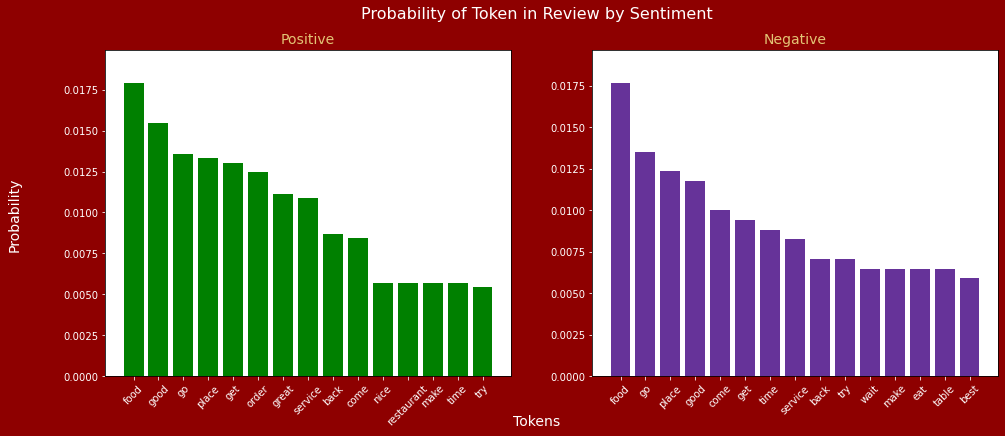

In [125]:
fig, axes = plt.subplots(1, 2, figsize = (16, 6))
fig.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', color = 'white', fontsize = 14)
fig.text(0.5, 0.01, 'Tokens', ha='center', color = 'white', fontsize = 14)
fig.patch.set_facecolor('#8E0000')
plt.suptitle('Probability of Token in Review by Sentiment', color = 'white', fontsize = 16)

axes[0].bar(proba_pos_15.index, proba_pos_15.values, color = 'green')
axes[0].set_ylim(0, (max(proba_pos_15.values) + 0.002))
axes[0].set_title('Positive', color = '#E3C375', fontsize = 14)
axes[0].set_xticks(np.arange(len(proba_pos_15.index)))
axes[0].set_xticklabels(proba_pos_15.index, rotation = 45)
axes[0].tick_params(axis = 'x', colors = 'white')
axes[0].tick_params(axis = 'y', colors = 'white')

axes[1].bar(proba_neg_15.index, proba_neg_15.values, color = 'rebeccapurple')
axes[1].set_ylim(0, (max(proba_neg_15.values) + 0.002))
axes[1].set_title('Negative', color = '#E3C375', fontsize = 14)
axes[1].set_xticks(np.arange(len(proba_neg_15.index)))
axes[1].set_xticklabels(proba_neg_15.index, rotation = 45)
axes[1].tick_params(axis = 'x', colors = 'white')
axes[1].tick_params(axis = 'y', colors = 'white')

plt.savefig('proba_unscaled.png', dpi=300)
plt.show();

#### Scaling Probabilities

The first issue that comes up is that some words have high probability of being positive and being negative, like "food".  This is because we used a Count Vectorizer, which doesn't take significance into account and instead just compares the frequency of a token to the target variable.  Below, I've shown the two bar graphs stacked on top of each other to show that the above graphs can be misleading.

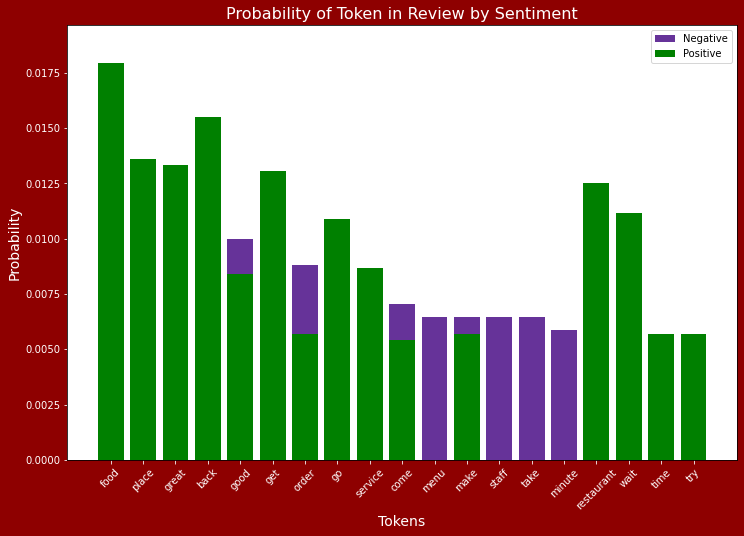

In [126]:
fig, ax = plt.subplots(figsize = (12, 8))
fig.patch.set_facecolor('#8E0000')
xlabels = ['food', 'place', 'great', 'back', 'good', 'get', 'order', 'go', 'service', 'come', 'menu', 'make', 'staff', 'take', 'minute', 'restaurant', 'wait', 'time', 'try']
ax.bar(proba_neg_15.index, proba_neg_15.values, color = 'rebeccapurple', label = 'Negative')
ax.bar(proba_pos_15.index, proba_pos_15.values, color = 'green', label = 'Positive')
ax.set_title('Probability of Token in Review by Sentiment', color = 'white', fontsize = 16)
ax.set_xlabel('Tokens', color = 'white', fontsize = 14)
ax.set_xticklabels(xlabels, rotation = 45)
ax.tick_params(axis = 'x', colors = 'white')
ax.set_ylabel('Probability', color = 'white', fontsize = 14)
ax.set_ylim(0, (max(proba_neg_15.values) + 0.002))
ax.tick_params(axis = 'y', colors = 'white')
ax.legend()

warnings.filterwarnings("ignore", category = UserWarning)
plt.savefig('proba_stacked.png', dpi=300)
plt.show()

In [127]:
true_proba_pos = proba_pos - proba_neg
true_proba_neg = proba_neg - proba_pos
true_proba_pos_15 = true_proba_pos.sort_values(ascending = False)[0:15]
true_proba_neg_15 = true_proba_neg.sort_values(ascending = False)[0:15]

#### Scaled Conclusion

After subtracting the negative probability from the positive and vice versa, we're left with the probability that a certain word will be positive or negative after accounting for how often it will appear in the opposite class.  Therefore, the words shown below are the best reflection of what makes up a positive or negative sentiment.

We can see that these results make more sense.  Words like "great", "wonderful", "hot", and "delicious" are clear indicators of positive sentiment, meanwhile words like "never" and "wait" are clearly negative.

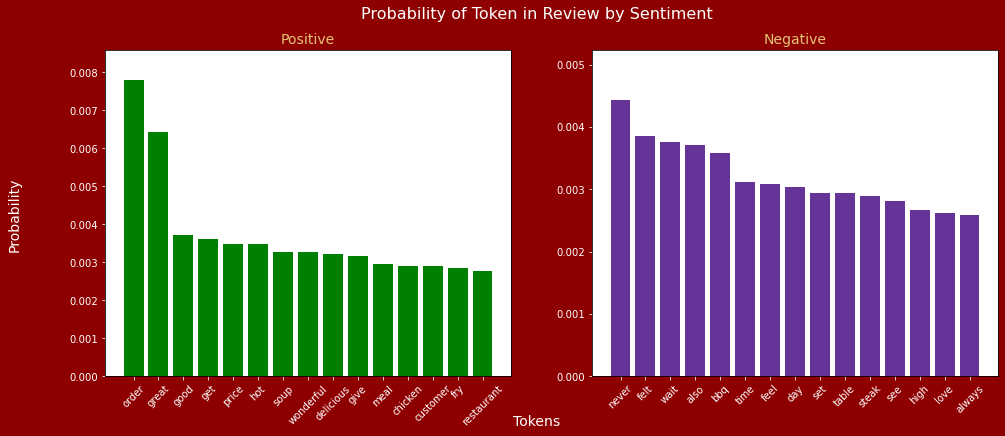

In [128]:
fig, axes = plt.subplots(1, 2, figsize = (16, 6))
fig.patch.set_facecolor('#8E0000')
fig.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', color = 'white', fontsize = 14)
fig.text(0.5, 0.01, 'Tokens', ha='center', color = 'white', fontsize = 14)
plt.suptitle('Probability of Token in Review by Sentiment', color = 'white', fontsize = 16)

axes[0].bar(true_proba_pos_15.index, true_proba_pos_15.values, color = 'green')
axes[0].set_ylim(0, (max(true_proba_pos_15.values) + 0.0008))
axes[0].set_title('Positive', color = '#E3C375', fontsize = 14)
axes[0].set_xticks(np.arange(len(true_proba_pos_15.index)))
axes[0].set_xticklabels(true_proba_pos_15.index, rotation = 45)
axes[0].tick_params(axis = 'x', colors = 'white')
axes[0].tick_params(axis = 'y', colors = 'white')

axes[1].bar(true_proba_neg_15.index, true_proba_neg_15.values, color = 'rebeccapurple')
axes[1].set_ylim(0, (max(true_proba_neg_15.values) + 0.0008))
axes[1].set_title('Negative', color = '#E3C375', fontsize = 14)
axes[1].set_xticks(np.arange(len(true_proba_neg_15.index)))
axes[1].set_xticklabels(true_proba_neg_15.index, rotation = 45)
axes[1].tick_params(axis = 'x', colors = 'white')
axes[1].tick_params(axis = 'y', colors = 'white')

plt.savefig('proba_true.png', dpi=300)
plt.show();

#### Conclusion and Next Steps

Overall, the model performs well with a very high accuracy on its predictions.  The accuracy score is 0.9358 and the AUC score is 0.96.

The probability graphs show more insight into which words appeared most often in their respective sentiments and thus, which subjects may be worth investigating to improve guest perception of a restaurant.  For instance, hot soup is cheap and easy to prepare and seems to be a hit with guests!  It might be worth talking to the chef and asking them to put hot soup on the menu.  Similarly, "fry" and "chicken" might imply that fried chicken is another big hit.  Not to mention that it is also relatively cheap!  On the other wise, we can see that waiting a long time and table placement/size are touchy.  Steaks are delicious but also have a large variance in preference.  Not to mention, expensive!  Many people love a good steak, but it may not be the most viable menu item.  These are just a few actionable insights a model like this can provide.

At this point, it is important to talk about the limitations of this project.  Most importantly, the data size.  Although our current model runs well and predicts accurately, that score can always be improved.  In the analysis of which model and vectorization method to use, it does appear that the TF-IDF vectorization combined with Complement Naive-Bayes could potentially be the best model on a larger scale.

However, accuracy isn't the only important result that is affected by data size.  The word-sentiment associations and probabilities are also affected.  In particular, the under-represented class (negative).  We can see that the words with the high probability of being in the positive class make more sense than those in the negative class.  This is likely because of the imbalance of classes.  In addition, because we used Count Vectorization, we got less information on which words have stronger significance with respect to sentiment.  TF-IDF would allow for words that rarely appear at all and words that appear too often in both classes to be eliminated, which would mean I wouldn't need to do the last step laid out in this notebook.

In the end, the model is accurate and does what I set out for it to do.  However, if I had more time, I believe I could have fed more information into the model and address class imbalance to provide better accuracy scores and more actionable results.